In [1]:
pip install zeus-mcmc

  Using cached zeus_mcmc-2.5.4-py3-none-any.whl (24 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy import integrate
from scipy.stats import multivariate_normal, uniform
from corner import corner
import zeus

# Q2

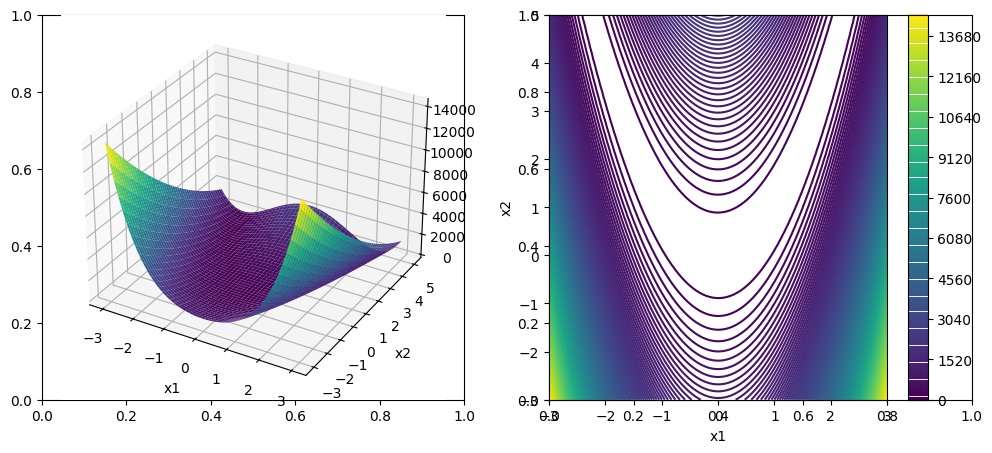

In [54]:
def f(x1,x2):
    return 100*(x2-x1**2)**2+(1-x1)**2

x1=np.linspace(-3,3,100)
x2=np.linspace(-3,5,100)

x1, x2 = np.meshgrid(x1, x2)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# surface plot of the joint pdf
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x1, x2, f(x1, x2), cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

# contour plot of the joint pdf
ax2 = fig.add_subplot(122)
c = ax2.contour(x1, x2, f(x1, x2), cmap='viridis', levels=200)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
cbar = fig.colorbar(c, ax=ax2)

plt.show()

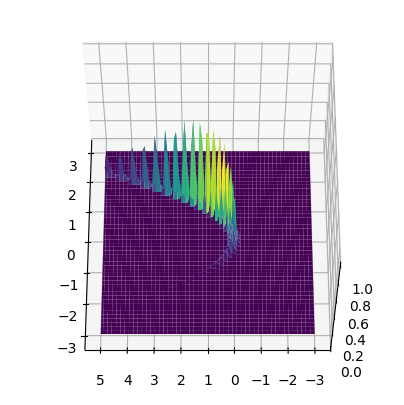

In [79]:
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw={"projection": "3d"})
ax.plot_surface(x1, x2, np.exp(-f(x1, x2)), cmap='viridis')

ax.view_init(60, 180)

# Q3

In [ ]:
# Define the target distribution P3
def P3(x1,x2,x3):
    f = lambda x1,x2,x3: 100*(x2-x1**2)**2+(1-x1)**2+100*(x3-x2**2)**2+(1-x2)**2
    return np.exp(-f(x1,x2,x3))

# Define the integrand
def expn_intgd(x1,x2,x3):
    return np.sqrt(x1**2+x2**2+x3**2)*P3(x1,x2,x3)


# Limits of integration
x_limits = [-np.inf, np.inf]
y_limits = [-np.inf, np.inf]
z_limits = [-np.inf, np.inf]

# Compute the integral via numerical integration (tplquad)
result, error = integrate.tplquad(expn_intgd, *x_limits, lambda x: y_limits[0], lambda x: y_limits[1], lambda x, y: z_limits[0], lambda x, y: z_limits[1])

print(f"Result: {result}, Error: {error}")


Result: 0.03999985166452838, Error: 1.9845945415800582e-05


c:\Users\fayza\.conda\envs\S1Coursework\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


# Q4

In [39]:
num_iterations, num_walkers, num_accept = 100000, 10, 0

# Copy the target distribution again here for convenience
def target_logPDF(x1,x2,x3):
    f = 100*(x2-x1**2)**2+(1-x1)**2+100*(x3-x2**2)**2+(1-x2)**2
    return -f

beta=0.9
covQ = np.array([[1,beta,beta],[beta,1,beta],[beta,beta,1]])*0.005

MC = np.zeros((num_iterations, num_walkers, 3))
acceptance_fraction = np.zeros(num_walkers)

for w in range(num_walkers):
    x_current = multivariate_normal.rvs(mean=np.array([0,0,0]), cov=covQ)
    MC[0,w] = x_current

    for i in range(1, num_iterations):
        x_proposed = multivariate_normal.rvs(mean=x_current, cov=covQ)

        log_a = target_logPDF(*x_proposed) - target_logPDF(*x_current)

        u = uniform.rvs()

        if np.log(u) < log_a:
            MC[i,w] = x_proposed
            num_accept += 1
        else:
            MC[i,w] = x_current

        x_current = MC[i,w]

    acceptance_fraction[w] = num_accept/num_iterations

print(f"Acceptance rates: {acceptance_fraction}")


Acceptance rates: [0.49604 1.04372 1.57842 2.17328 2.70497 3.27611 3.88054 4.40535 4.9561
 5.27418]


In [41]:
print(MC.shape)
# Flatten the MC array
samples = MC.reshape((-1, 3))
print(samples.shape)

(100000, 10, 3)
(1000000, 3)


Make a corner plot of the samples 

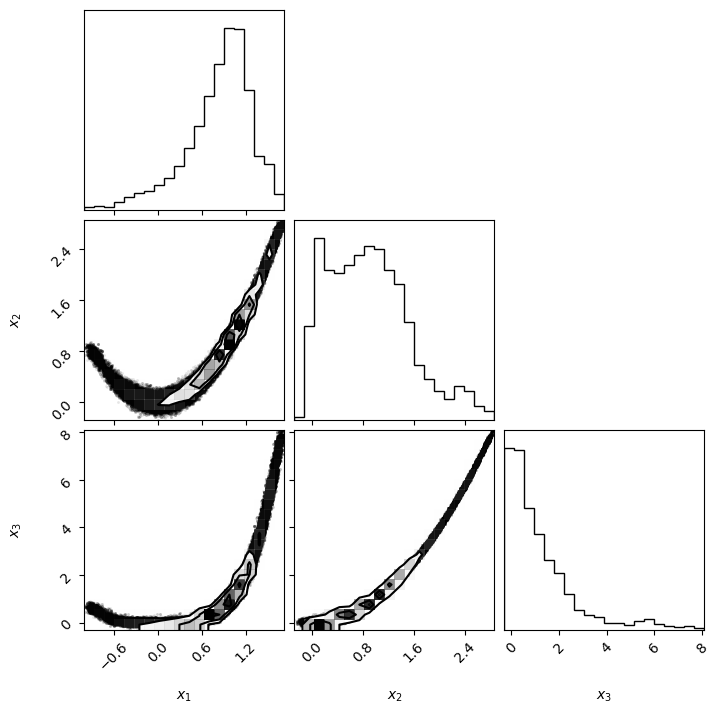

In [42]:
corner(samples, labels=[r"$x_1$", r"$x_2$", r"$x_3$"])
plt.show()

In [47]:
modulus = np.sqrt(np.sum(samples**2, axis=1))
print(modulus.shape)
print(f'Expectation estimate: {np.mean(modulus)}')
print(f'Error on estimate: {np.sqrt(np.var(modulus))/np.sqrt(num_iterations*num_walkers)}')

(1000000,)
Expectation estimate: 1.837455976132968
Error on estimate: 0.0015463504986741262


Trace plots look ok

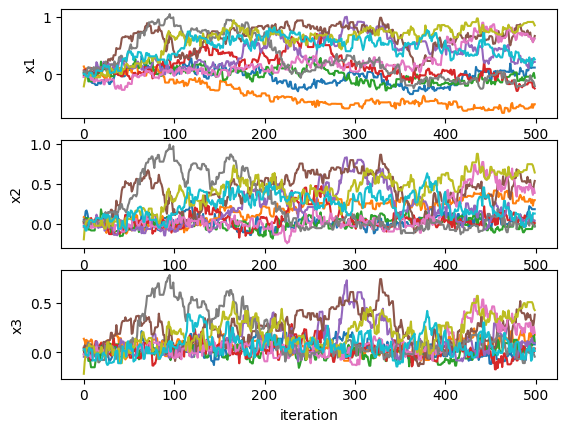

In [49]:

# Consider the first 200 iterations of the chains
plot_first = 500
# Trace plot of the chains for the walkers in each dimension
fig, ax = plt.subplots(nrows=3)
for walker in range(num_walkers):
  ax[0].plot(MC[:plot_first,walker,0])
  ax[1].plot(MC[:plot_first,walker,1])
  ax[2].plot(MC[:plot_first,walker,2])
ax[0].set_ylabel('x1')
ax[1].set_ylabel('x2')
ax[2].set_ylabel('x3')
ax[2].set_xlabel('iteration')
plt.show()

# Q5

In [23]:
# Copy the target distribution again here for convenience
def target_logPDF(x):
    x1, x2, x3 = x
    f = 100*(x2-x1**2)**2+(1-x1)**2+100*(x3-x2**2)**2+(1-x2)**2
    return -f


nsteps, nwalkers, ndim = 100000, 100, 3

# Initial positions of the walkers
x0 = np.random.normal(size=(nwalkers, ndim))


# Callback functions for IAT and GR statistic
cb0 = zeus.callbacks.AutocorrelationCallback(ncheck=100, dact=0.01, nact=50, discard=0.5)
cb1 = zeus.callbacks.SplitRCallback(ncheck=100, epsilon=0.01, nsplits=2, discard=0.5)

# Create the sampler
sampler = zeus.EnsembleSampler(nwalkers, ndim, target_logPDF)

# Run the MCMC with callbacks
state=sampler.run_mcmc(x0, nsteps, callbacks=[cb0, cb1])



Initialising ensemble of 100 walkers...
Sampling progress : 100%|██████████| 100000/100000 [2:08:08<00:00, 13.01it/s] 


Too few points to create valid contours


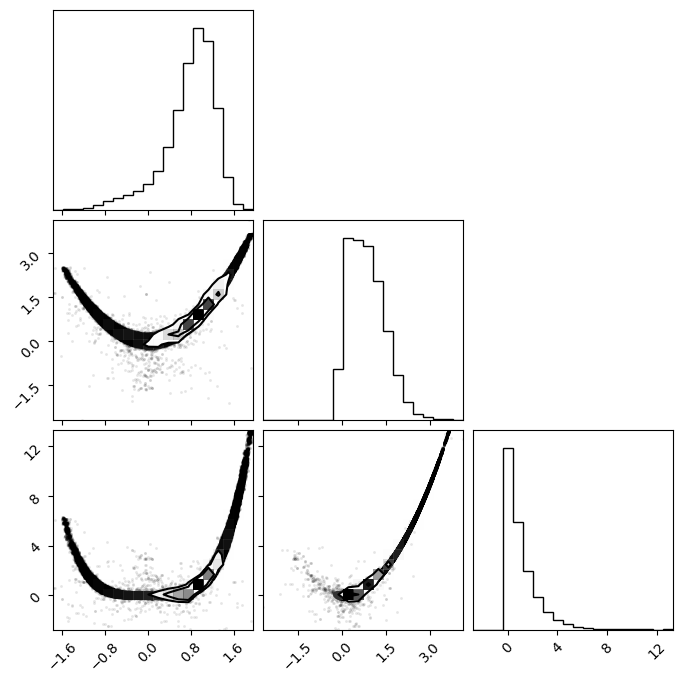

In [24]:
corner(sampler.get_chain(flat=True))
plt.show()

In [32]:
chain = sampler.get_chain(flat=True)
modulus = np.sqrt(np.sum(chain**2, axis=1))
print(modulus.shape)
print(f'Expectation estimate: {np.mean(modulus)}')
print(f'Error on estimate: {np.sqrt(np.var(modulus))/np.sqrt(nsteps)}')

(10000000,)
Expectation estimate: 1.6905389621828866
Error on estimate: 0.004361564503754778


In [33]:
chain.shape

(10000000, 3)

Trace plots - good mixing of walkers, no drift, no trends. Exploring the parameter space well.

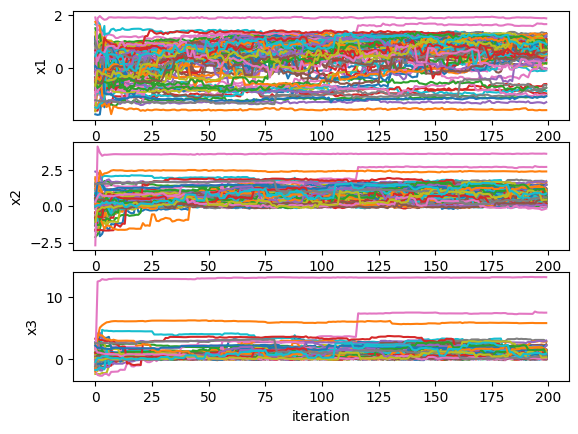

In [26]:
# Get the samples 
chains = sampler.get_chain()
# Consider the first 200 iterations of the chains
plot_first = 200
# Trace plot of the chains for the walkers in each dimension
fig, ax = plt.subplots(nrows=3)
for walker in range(nwalkers):
  ax[0].plot(chains[:plot_first,walker,0])
  ax[1].plot(chains[:plot_first,walker,1])
  ax[2].plot(chains[:plot_first,walker,2])
ax[0].set_ylabel('x1')
ax[1].set_ylabel('x2')
ax[2].set_ylabel('x3')
ax[2].set_xlabel('iteration')
plt.show()

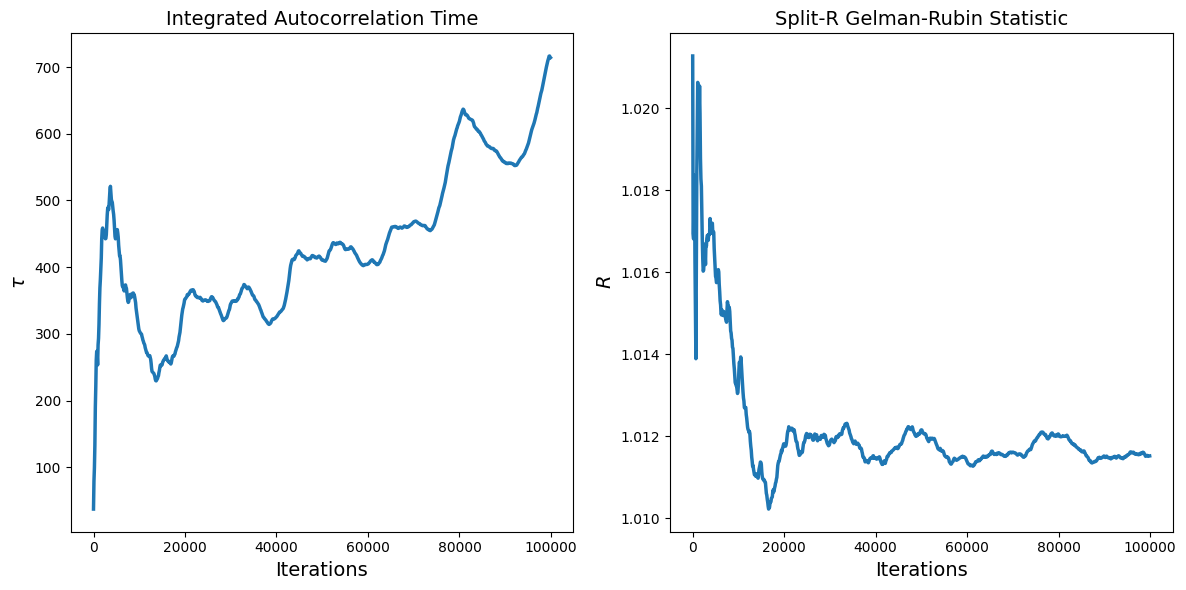

In [27]:
tau = cb0.estimates
R = cb1.estimates

N = np.arange(len(tau)) * 100


plt.figure(figsize=(12,6))
plt.subplot(121)

plt.plot(N, tau, lw=2.5)
plt.title('Integrated Autocorrelation Time', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'$\tau$', fontsize=14)


plt.subplot(122)

plt.plot(N, R, lw=2.5)
plt.title('Split-R Gelman-Rubin Statistic', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'$R$', fontsize=14)

plt.tight_layout()
plt.show()